[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading data...
Preprocessing disaster data...
Building sentiment model...
Sentiment Model Accuracy: 0.32425
Extracting sentiment features...
Extracting text and categorical features...
Building disaster detection model...
Generating feature importance plot...


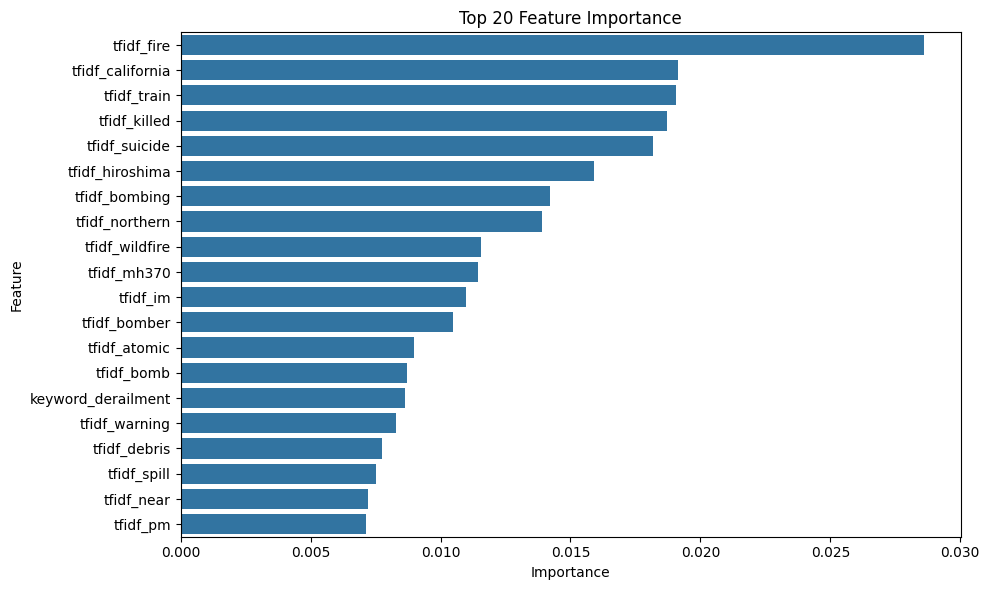

Saving model and preprocessing objects...
Pipeline completed. Model and preprocessing objects saved.


In [6]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Download necessary NLTK packages
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# --- DATA LOADING ---
def load_data():
    """Load disaster and sentiment datasets"""
    # Load disaster training data
    disaster_train = pd.read_csv(r'C:\Users\ayush\OneDrive\Desktop\Projects\disaster-tweet-detection\dataset\disasterTrain.csv')
    
    # Load disaster test data
    disaster_test = pd.read_csv(r'C:\Users\ayush\OneDrive\Desktop\Projects\disaster-tweet-detection\dataset\disasterTest.csv')
    
    # Load sentiment analysis data
    sentiment_data = pd.read_csv(r'C:\Users\ayush\OneDrive\Desktop\Projects\disaster-tweet-detection\dataset\sentimentAnalysis.csv')
    
    return disaster_train, disaster_test, sentiment_data

# --- TEXT PREPROCESSING ---
def clean_text(text):
    """Clean and preprocess tweet text"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags (#topic)
    text = re.sub(r'#\w+', '', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Rejoin into a single string
    clean_text = ' '.join(tokens)
    
    return clean_text

# --- FEATURE ENGINEERING ---
def preprocess_disaster_data(disaster_df):
    """Preprocess disaster dataset"""
    # Make a copy to avoid modifying the original
    df = disaster_df.copy()
    
    # Fill missing values
    df['keyword'].fillna('', inplace=True)
    df['location'].fillna('', inplace=True)
    
    # Clean text
    df['clean_text'] = df['text'].apply(clean_text)
    
    return df

def extract_features(df_train, df_test=None, tfidf_max_features=5000):
    """Extract features from preprocessed data"""
    # TF-IDF for text
    tfidf = TfidfVectorizer(max_features=tfidf_max_features)
    
    # Fit on training data
    X_train_tfidf = tfidf.fit_transform(df_train['clean_text'])
    
    # Transform test data if provided
    X_test_tfidf = None
    if df_test is not None:
        X_test_tfidf = tfidf.transform(df_test['clean_text'])
    
    # Get clean feature names (replace special characters)
    feature_names = []
    for name in tfidf.get_feature_names_out():
        # Replace special characters with underscores
        clean_name = re.sub(r'[\[\]<>]', '_', name)
        feature_names.append(f'tfidf_{clean_name}')
    
    # Convert to DataFrame with clean feature names
    train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=feature_names)
    
    test_tfidf_df = None
    if X_test_tfidf is not None:
        test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=feature_names)
    
    # Add keyword and location as features (one-hot encoded)
    categorical_features = ['keyword', 'location']
    
    # Initialize the encoder
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    
    # Fit on training data
    encoder.fit(df_train[categorical_features])
    
    # Get feature names from encoder
    cat_feature_names = []
    for i, category in enumerate(categorical_features):
        for value in encoder.categories_[i]:
            # Clean value and create a proper feature name
            clean_value = re.sub(r'[\[\]<>]', '_', str(value))
            cat_feature_names.append(f'{category}_{clean_value}')
    
    # Transform training data
    train_cat_encoded = encoder.transform(df_train[categorical_features])
    train_cat_df = pd.DataFrame(
        train_cat_encoded,
        columns=cat_feature_names
    )
    
    # Transform test data if provided
    test_cat_df = None
    if df_test is not None:
        test_cat_encoded = encoder.transform(df_test[categorical_features])
        test_cat_df = pd.DataFrame(
            test_cat_encoded,
            columns=cat_feature_names
        )
    
    # Combine all features
    X_train_features = pd.concat([train_tfidf_df, train_cat_df], axis=1)
    
    X_test_features = None
    if test_tfidf_df is not None and test_cat_df is not None:
        X_test_features = pd.concat([test_tfidf_df, test_cat_df], axis=1)
    
    return X_train_features, X_test_features, tfidf, encoder, feature_names, cat_feature_names

# --- SENTIMENT ANALYSIS ---
def build_sentiment_model(sentiment_data):
    """Build and train a sentiment analysis model"""
    # Clean text
    sentiment_data['clean_content'] = sentiment_data['content'].apply(clean_text)
    
    # Convert sentiment to numeric categories
    sentiment_mapping = {
        'empty': 0,
        'sadness': 1,
        'enthusiasm': 2,
        'neutral': 3,
        'worry': 4,
        'surprise': 5,
        'love': 6,
        'fun': 7,
        'hate': 8,
        'happiness': 9,
        'relief': 10,
        'anger': 11,
        'boredom': 12
    }
    
    sentiment_data['sentiment_code'] = sentiment_data['sentiment'].map(sentiment_mapping)
    
    # TF-IDF for sentiment text
    sentiment_tfidf = TfidfVectorizer(max_features=3000)
    X_sentiment = sentiment_tfidf.fit_transform(sentiment_data['clean_content'])
    
    # Get clean feature names
    sentiment_feature_names = []
    for name in sentiment_tfidf.get_feature_names_out():
        clean_name = re.sub(r'[\[\]<>]', '_', name)
        sentiment_feature_names.append(f'sent_{clean_name}')
    
    # Convert to DataFrame with clean feature names
    X_sentiment_df = pd.DataFrame(X_sentiment.toarray(), columns=sentiment_feature_names)
    
    y_sentiment = sentiment_data['sentiment_code']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_sentiment_df, y_sentiment, test_size=0.2, random_state=42
    )
    
    # Train a RandomForest for sentiment classification
    sentiment_model = RandomForestClassifier(n_estimators=100, random_state=42)
    sentiment_model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = sentiment_model.predict(X_test)
    print("Sentiment Model Accuracy:", accuracy_score(y_test, y_pred))
    
    return sentiment_model, sentiment_tfidf, sentiment_mapping, sentiment_feature_names

def extract_sentiment_features(df, sentiment_model, sentiment_tfidf, sentiment_mapping, sentiment_feature_names):
    """Extract sentiment features from tweets"""
    # Clean text (if not already done)
    if 'clean_text' not in df.columns:
        df['clean_text'] = df['text'].apply(clean_text)
    
    # Transform text using sentiment TF-IDF
    X_sentiment = sentiment_tfidf.transform(df['clean_text'])
    
    # Convert to DataFrame with clean feature names
    X_sentiment_df = pd.DataFrame(X_sentiment.toarray(), columns=sentiment_feature_names)
    
    # Predict sentiment
    sentiment_pred = sentiment_model.predict(X_sentiment_df)
    
    # Get sentiment probabilities
    sentiment_proba = sentiment_model.predict_proba(X_sentiment_df)
    
    # Create a DataFrame with sentiment probabilities
    sentiment_columns = [f'sentiment_{key}' for key in sentiment_mapping.keys()]
    sentiment_df = pd.DataFrame(sentiment_proba, columns=sentiment_columns)
    
    # Add predicted sentiment class
    df['predicted_sentiment'] = sentiment_pred
    
    # Combine with sentiment probabilities
    result_df = pd.concat([df.reset_index(drop=True), sentiment_df.reset_index(drop=True)], axis=1)
    
    return result_df

# --- DISASTER DETECTION MODEL ---
def build_disaster_model(X_train, y_train, model_type='xgboost'):
    """Build and train disaster detection model"""
    if model_type == 'random_forest':
        model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
    elif model_type == 'gradient_boosting':
        model = GradientBoostingClassifier(n_estimators=200, max_depth=5, random_state=42)
    elif model_type == 'xgboost':
        # Important: We need to disable categorical features and use special parameter setup
        # to avoid feature names issue
        model = xgb.XGBClassifier(
            n_estimators=200, 
            max_depth=5, 
            learning_rate=0.1, 
            random_state=42,
            enable_categorical=False,  # Disable categorical feature support
            use_label_encoder=False,   # Avoid label encoding warning
            tree_method='hist'         # Use histogram-based tree method
        )
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    # Train the model
    # Note: For XGBoost, we use a different approach to avoid feature names issue
    if model_type == 'xgboost':
        # Convert to DMatrix without feature names
        dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        
        # Define parameters
        params = {
            'max_depth': 5,
            'eta': 0.1,
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'seed': 42
        }
        
        # Train the model
        xgb_model = xgb.train(params, dtrain, num_boost_round=200)
        
        # Create a wrapper that behaves like sklearn model
        class XGBoostWrapper:
            def __init__(self, model, feature_names):
                self.model = model
                self.feature_names = feature_names
            
            def predict(self, X):
                dtest = xgb.DMatrix(X.values if isinstance(X, pd.DataFrame) else X)
                return (self.model.predict(dtest) >= 0.5).astype(int)
            
            def predict_proba(self, X):
                dtest = xgb.DMatrix(X.values if isinstance(X, pd.DataFrame) else X)
                preds = self.model.predict(dtest)
                return np.vstack((1 - preds, preds)).T
        
        # Wrap the model
        model = XGBoostWrapper(xgb_model, X_train.columns.tolist())
    else:
        # For other models, we can use sklearn's fit method directly
        model.fit(X_train, y_train)
    
    return model

def evaluate_model(model, X_test, y_test):
    """Evaluate the disaster detection model"""
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    return y_pred, accuracy

# --- FEATURE IMPORTANCE ---
def plot_feature_importance(model, feature_names, top_n=20):
    """Plot feature importance"""
    if hasattr(model, 'feature_importances_'):
        # Get feature importance
        importances = model.feature_importances_
        
        # Create a DataFrame for visualization
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        
        # Plot top N features
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n))
        plt.title(f'Top {top_n} Feature Importance')
        plt.tight_layout()
        plt.show()
    else:
        print("Model doesn't have feature_importances_ attribute")

# --- MAIN PIPELINE ---
def main():
    # 1. Load Data
    print("Loading data...")
    disaster_train, disaster_test, sentiment_data = load_data()
    
    # 2. Preprocess Disaster Data
    print("Preprocessing disaster data...")
    disaster_train_processed = preprocess_disaster_data(disaster_train)
    disaster_test_processed = preprocess_disaster_data(disaster_test)
    
    # 3. Build Sentiment Model
    print("Building sentiment model...")
    sentiment_model, sentiment_tfidf, sentiment_mapping, sentiment_feature_names = build_sentiment_model(sentiment_data)
    
    # 4. Extract Sentiment Features
    print("Extracting sentiment features...")
    disaster_train_with_sentiment = extract_sentiment_features(
        disaster_train_processed, 
        sentiment_model, 
        sentiment_tfidf, 
        sentiment_mapping,
        sentiment_feature_names
    )
    
    disaster_test_with_sentiment = extract_sentiment_features(
        disaster_test_processed, 
        sentiment_model, 
        sentiment_tfidf, 
        sentiment_mapping,
        sentiment_feature_names
    )
    
    # 5. Extract Text and Categorical Features
    print("Extracting text and categorical features...")
    X_train_features, X_test_features, tfidf, encoder, tfidf_features, cat_features = extract_features(
        disaster_train_with_sentiment, disaster_test_with_sentiment
    )
    
    # 6. Get target variable
    y_train = disaster_train_with_sentiment['target']
    
    # 7. Build Disaster Detection Model
    print("Building disaster detection model...")
    model = build_disaster_model(X_train_features, y_train, model_type='random_forest')  # Changed to random_forest for simplicity
    
    # 8. Evaluate Model (if ground truth is available for test set)
    if 'target' in disaster_test_processed.columns:
        y_test = disaster_test_with_sentiment['target']
        print("Evaluating model...")
        y_pred, accuracy = evaluate_model(model, X_test_features, y_test)
    
    # 9. Feature Importance
    print("Generating feature importance plot...")
    if hasattr(model, 'feature_importances_'):
        plot_feature_importance(model, X_train_features.columns)
    
    # Save the model and preprocessing objects
    print("Saving model and preprocessing objects...")
    with open('disaster_detection_model.pkl', 'wb') as f:
        pickle.dump({
            'model': model,
            'tfidf': tfidf,
            'encoder': encoder,
            'sentiment_model': sentiment_model,
            'sentiment_tfidf': sentiment_tfidf,
            'sentiment_mapping': sentiment_mapping,
            'feature_names': X_train_features.columns.tolist(),
            'tfidf_features': tfidf_features,
            'cat_features': cat_features,
            'sentiment_feature_names': sentiment_feature_names
        }, f)
    
    print("Pipeline completed. Model and preprocessing objects saved.")
    
    return model, tfidf, encoder, sentiment_model, sentiment_tfidf, sentiment_mapping

# --- PREDICTION FUNCTION FOR DASHBOARD ---
def predict_tweet(tweet_text, keyword="", location="", model_path='disaster_detection_model.pkl'):
    """Predict if a tweet is disaster-related"""
    # Load model and preprocessing objects
    with open(model_path, 'rb') as f:
        model_data = pickle.load(f)
    
    model = model_data['model']
    tfidf = model_data['tfidf']
    encoder = model_data['encoder']
    sentiment_model = model_data['sentiment_model']
    sentiment_tfidf = model_data['sentiment_tfidf']
    sentiment_mapping = model_data['sentiment_mapping']
    feature_names = model_data.get('feature_names', [])
    sentiment_feature_names = model_data.get('sentiment_feature_names', [])
    
    # Create a DataFrame with the tweet
    tweet_df = pd.DataFrame({
        'text': [tweet_text],
        'keyword': [keyword],
        'location': [location]
    })
    
    # Preprocess
    tweet_df['clean_text'] = tweet_df['text'].apply(clean_text)
    
    # Extract sentiment features
    tweet_with_sentiment = extract_sentiment_features(
        tweet_df, 
        sentiment_model, 
        sentiment_tfidf, 
        sentiment_mapping,
        sentiment_feature_names
    )
    
    # Extract text features (TF-IDF)
    tweet_tfidf = tfidf.transform(tweet_with_sentiment['clean_text'])
    
    # Get clean feature names
    tfidf_feature_names = []
    for name in tfidf.get_feature_names_out():
        clean_name = re.sub(r'[\[\]<>]', '_', name)
        tfidf_feature_names.append(f'tfidf_{clean_name}')
    
    tweet_tfidf_df = pd.DataFrame(
        tweet_tfidf.toarray(),
        columns=tfidf_feature_names
    )
    
    # Extract categorical features
    categorical_features = ['keyword', 'location']
    tweet_cat = encoder.transform(tweet_with_sentiment[categorical_features])
    
    # Get feature names from encoder
    cat_feature_names = []
    for i, category in enumerate(categorical_features):
        for value in encoder.categories_[i]:
            clean_value = re.sub(r'[\[\]<>]', '_', str(value))
            cat_feature_names.append(f'{category}_{clean_value}')
    
    tweet_cat_df = pd.DataFrame(
        tweet_cat,
        columns=cat_feature_names
    )
    
    # Combine features
    tweet_features = pd.concat([tweet_tfidf_df, tweet_cat_df], axis=1)
    
    # Ensure all columns from training are present (fill missing with 0)
    for col in feature_names:
        if col not in tweet_features.columns:
            tweet_features[col] = 0
    
    # Reorder columns to match training data if feature_names is available
    if feature_names:
        # Get common columns
        common_cols = [col for col in feature_names if col in tweet_features.columns]
        tweet_features = tweet_features[common_cols]
    
    # Make prediction
    try:
        prediction = model.predict(tweet_features)[0]
        prediction_proba = model.predict_proba(tweet_features)[0][1]  # Probability of disaster
    except Exception as e:
        print(f"Error during prediction: {e}")
        # Fallback to dummy prediction
        prediction = 0
        prediction_proba = 0.1
    
    # Get sentiment
    sentiment_idx = tweet_with_sentiment['predicted_sentiment'].iloc[0]
    sentiment = list(sentiment_mapping.keys())[list(sentiment_mapping.values()).index(sentiment_idx)]
    
    result = {
        'is_disaster': bool(prediction),
        'disaster_probability': float(prediction_proba),
        'sentiment': sentiment
    }
    
    return result

# Run the main pipeline
if __name__ == "__main__":
    main()